In [1]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO
import numpy as np

In [2]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
version_name = 'universenet101_gfl_fp16_4x4_mstrain_480_960_2x_coco_randomfog'
cfg = Config.fromfile(f'/opt/ml/detection/mmdetection_universe/work_dirs/{version_name}/{version_name}.py')

root='/opt/ml/detection/dataset/'

epoch = 'latest'

# dataset config 수정
cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json'
# cfg.data.test.pipeline[1]['img_scale'] = (1024,1024) # Resize
# cfg.data.test.pipeline[1]['flip'] = True #TTA

cfg.data.test.test_mode = True

cfg.data.samples_per_gpu = 4

cfg.seed=2021
cfg.gpu_ids = [1]
cfg.work_dir = f'/opt/ml/detection/mmdetection_universe/work_dirs/{version_name}'

# for a_head in cfg.model.roi_head.bbox_head:
#     a_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.model.train_cfg = None

In [3]:
# build dataset & dataloader
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        samples_per_gpu=1,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
# checkpoint path
checkpoint_path = os.path.join(cfg.work_dir, f'{epoch}.pth')

model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg')) # build detector
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu') # ckpt load

model.CLASSES = dataset.CLASSES
model = MMDataParallel(model.cuda(), device_ids=[0])

/opt/ml/detection/mmdetection_universe/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


2021-10-12 07:56:02,344 - root - INFO - DeformConv2dPack backbone.layer2.0.convs.0 is upgraded to version 2.
2021-10-12 07:56:02,347 - root - INFO - DeformConv2dPack backbone.layer2.0.convs.1 is upgraded to version 2.
2021-10-12 07:56:02,349 - root - INFO - DeformConv2dPack backbone.layer2.0.convs.2 is upgraded to version 2.
2021-10-12 07:56:02,356 - root - INFO - DeformConv2dPack backbone.layer2.1.convs.0 is upgraded to version 2.
2021-10-12 07:56:02,358 - root - INFO - DeformConv2dPack backbone.layer2.1.convs.1 is upgraded to version 2.
2021-10-12 07:56:02,360 - root - INFO - DeformConv2dPack backbone.layer2.1.convs.2 is upgraded to version 2.
2021-10-12 07:56:02,369 - root - INFO - DeformConv2dPack backbone.layer2.2.convs.0 is upgraded to version 2.
2021-10-12 07:56:02,370 - root - INFO - DeformConv2dPack backbone.layer2.2.convs.1 is upgraded to version 2.
2021-10-12 07:56:02,371 - root - INFO - DeformConv2dPack backbone.layer2.2.convs.2 is upgraded to version 2.
2021-10-12 07:56:02

In [5]:
output = single_gpu_test(model, data_loader, show_score_thr=0.05) # output 계산

[                                ] 1/4871, 1.0 task/s, elapsed: 1s, ETA:  4861s

/opt/ml/detection/mmdetection_universe/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/opt/ml/detection/mmdetection_universe/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4871/4871, 3.8 task/s, elapsed: 1268s, ETA:     0s

In [6]:
# submission 양식에 맞게 output 후처리
prediction_strings = []
file_names = []
coco = COCO(cfg.data.test.ann_file)
img_ids = coco.getImgIds()

class_num = 10
for i, out in enumerate(output):
    prediction_string = ''
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    for j in range(class_num):
        for o in out[j]:
            prediction_string += str(j) + ' ' + str(o[4]) + ' ' + str(o[0]) + ' ' + str(o[1]) + ' ' + str(
                o[2]) + ' ' + str(o[3]) + ' '
        
    prediction_strings.append(prediction_string)
    file_names.append(image_info['file_name'])


submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv(os.path.join(cfg.work_dir, f'submission_universe_mixup_randomfog_flip.csv'), index=None)
submission.head()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


,PredictionString,image_id
0,0 0.37558135 221.11406 682.4201 301.05774 748....,test/0000.jpg
1,0 0.6208749 765.258 666.0538 898.89923 992.002...,test/0001.jpg
2,0 0.65353096 879.9766 467.7126 1023.0672 636.7...,test/0002.jpg
3,0 0.29476267 3.0927343 1.1227344 1024.0 1023.3...,test/0003.jpg
4,0 0.601717 427.41895 407.82852 657.1127 577.02...,test/0004.jpg


In [7]:
import matplotlib.pyplot as plt
import cv2
def show_predict(i):
    '''
    i번째 test이미지의 detection 결과를 보여줌
    '''
    plt.figure(figsize=(8,8))
    classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
    img = cv2.imread(os.path.join("/opt/ml/detection/dataset/",image_info['file_name']))
    out = output[i]
    for j in range(class_num):
        for o in out[j]:
            x, y, w, h = o[:4].astype(int)
            img = cv2.rectangle(img, (x, y), (w, h), colors[j], 2)
            img = cv2.putText(img, classes[j], (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 2, colors[j], 3)
    plt.imshow(img)

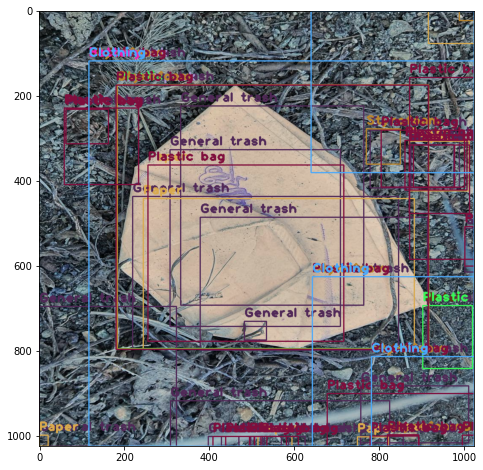

In [8]:
show_predict(1414)